In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results.logs")
logger.propagate = False

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")
split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(1100, 2252, 2) # Set wavelength range
pipeline_run_types = util.get_config_values("pipeline_run_types")

<h3 style="color: #eeaf23">Data Import, Split and Visualization</h3>

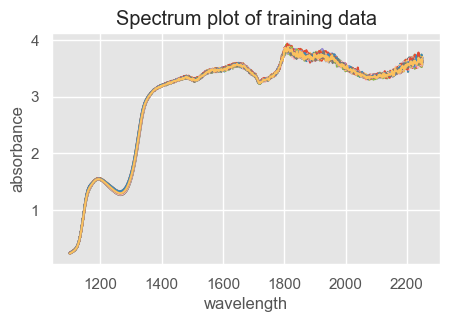

In [4]:
# for only one file - write dataset = files[index] (index maybe 0-3).
# For multiple files set value as list. e.g. - [files[0],files[2]]
# for all files, set dataset = files
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[0]), showDataEDA=False)

# plot raw training spectrum
util.plot(x_axis_data=wl, y_axis_data=X_train, title='Spectrum plot of training data', xlabel='wavelength',
     ylabel='absorbance')


<h3 style="color: #eeaf23">Running all preprocessors to find best results</h3>

INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol0, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


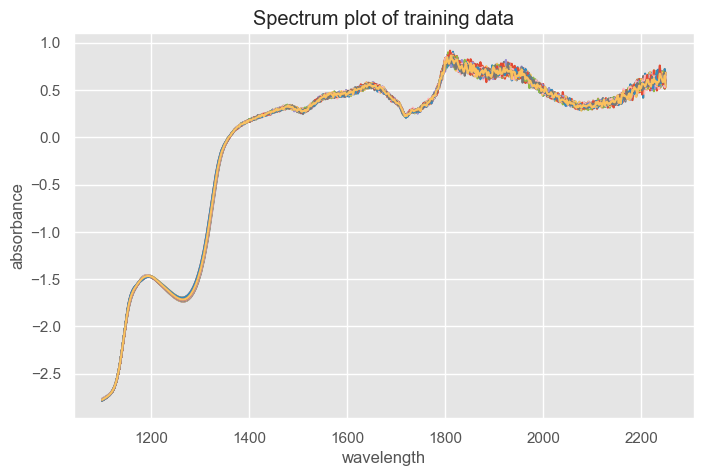

INFO [PRE PROCESSING]


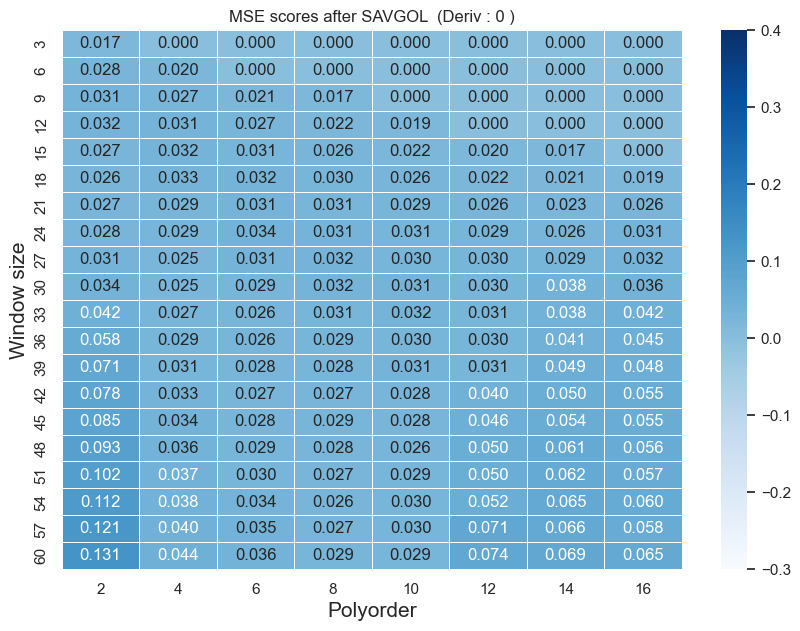

INFO Least MSE from SAVGOL loop run 0.01730994113482184
INFO Best window size 9
INFO Best polyorder 8


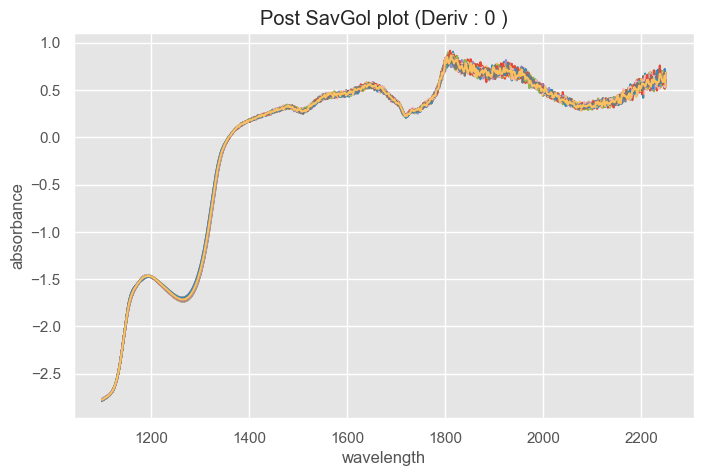

INFO Elapsed time for pipeline run : 1.17
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol1, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


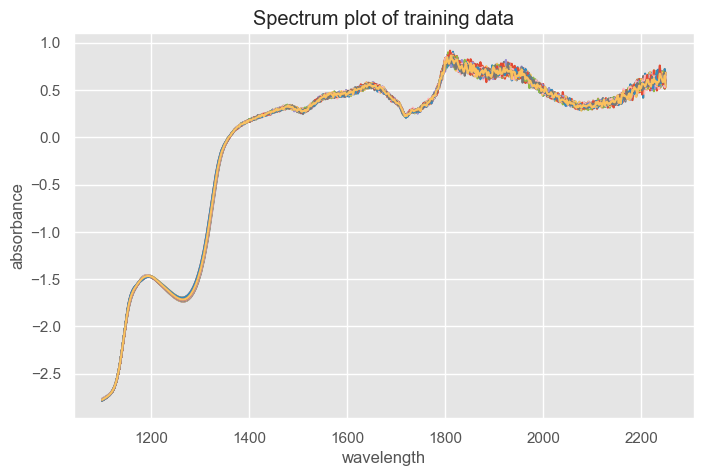

INFO [PRE PROCESSING]


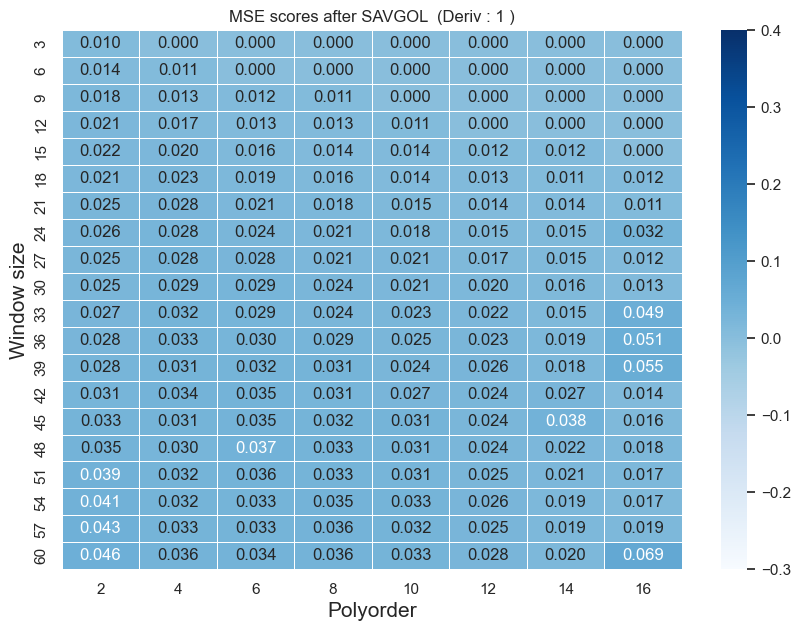

INFO Least MSE from SAVGOL loop run 0.01030762737684084
INFO Best window size 3
INFO Best polyorder 2


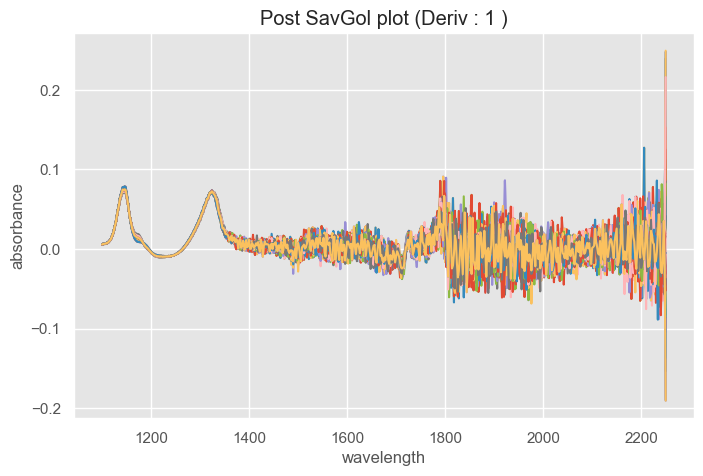

INFO Elapsed time for pipeline run : 1.16
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol2, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


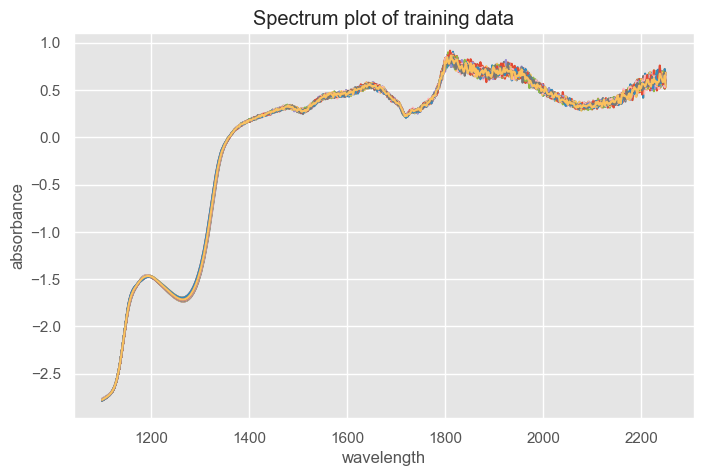

INFO [PRE PROCESSING]


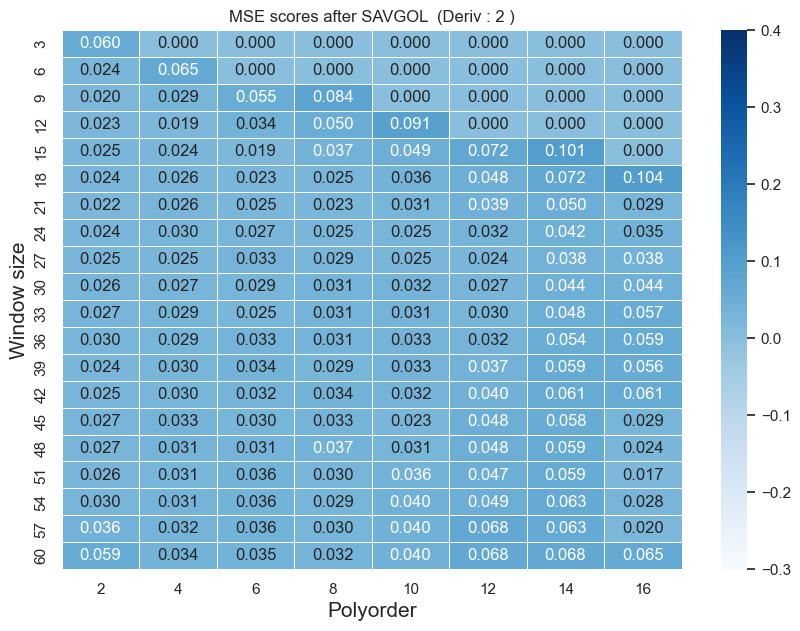

INFO Least MSE from SAVGOL loop run 0.017229880942294155
INFO Best window size 51
INFO Best polyorder 16


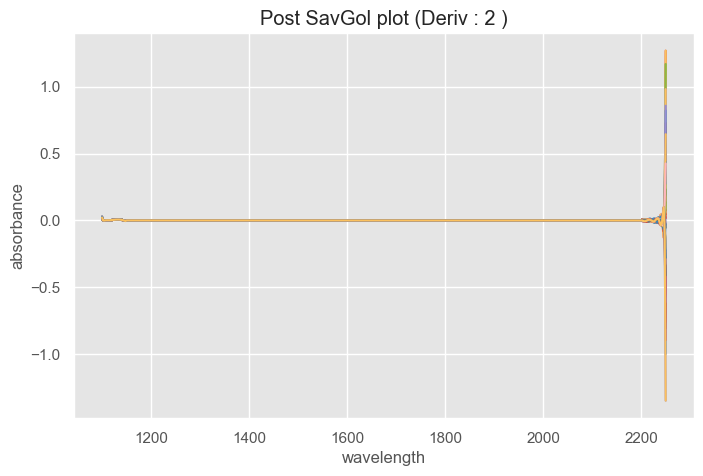

INFO Elapsed time for pipeline run : 1.04
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : snv, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


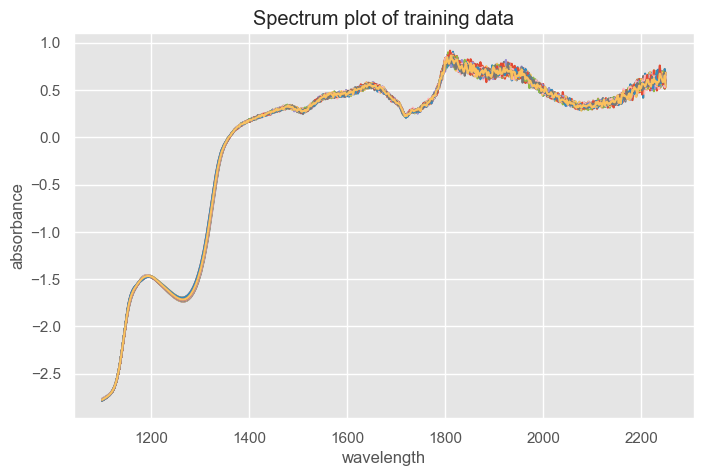

INFO [PRE PROCESSING]


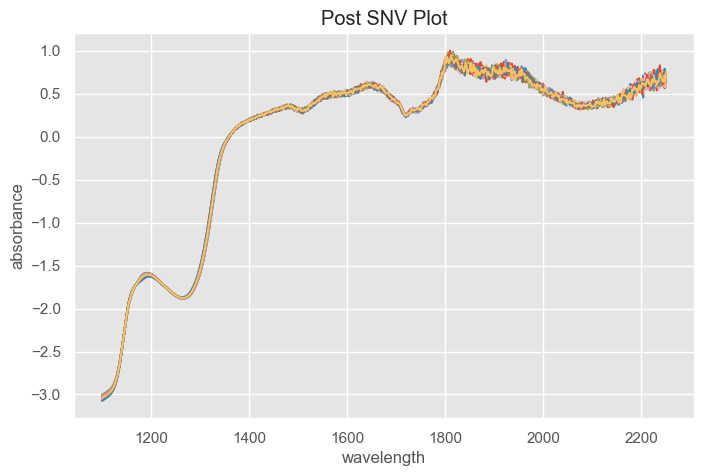

INFO Elapsed time for pipeline run : 0.26
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : msc, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


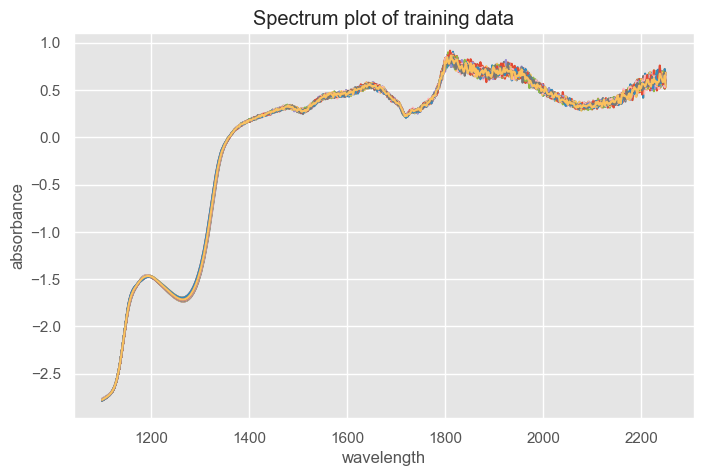

INFO [PRE PROCESSING]


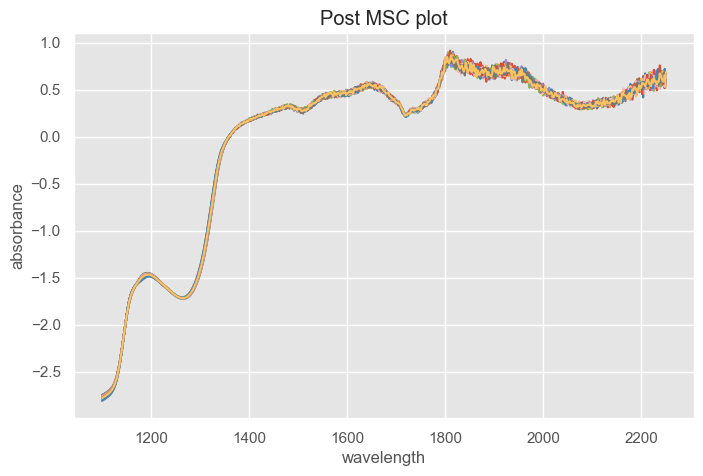

INFO Elapsed time for pipeline run : 0.38
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol0+snv, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


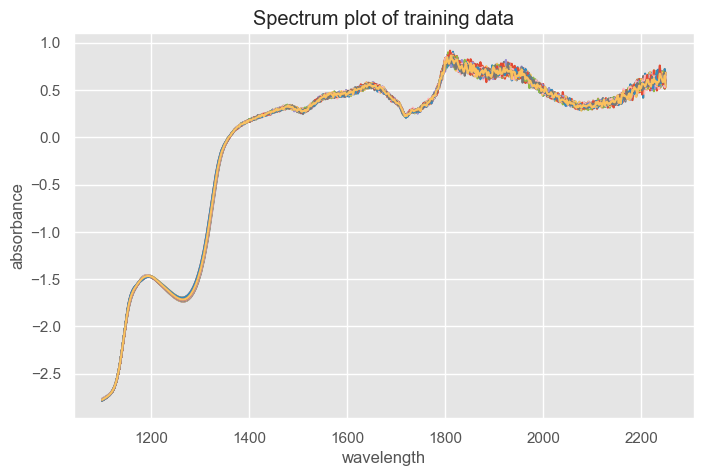

INFO [PRE PROCESSING]


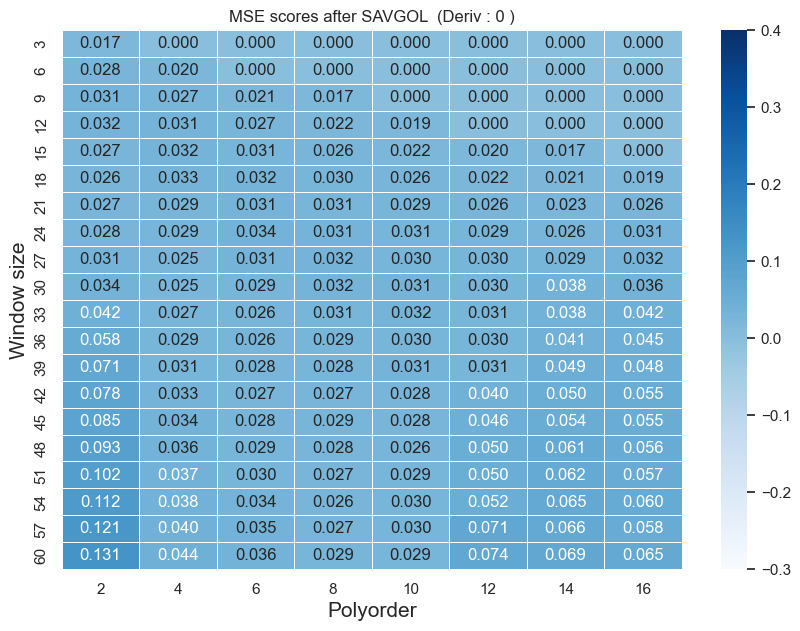

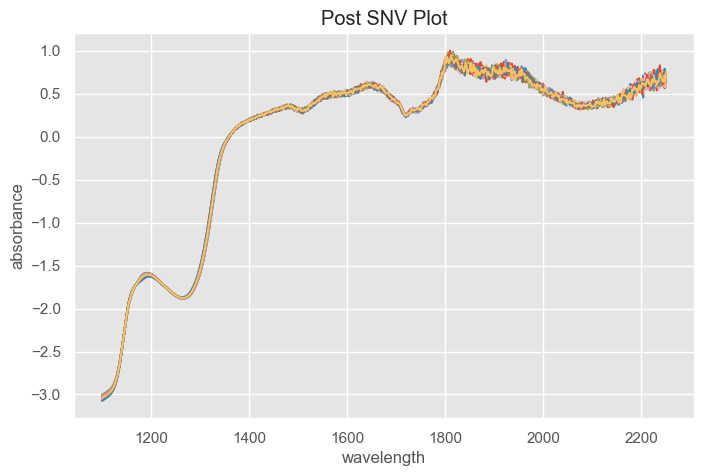

INFO Elapsed time for pipeline run : 1.04
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol1+snv, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


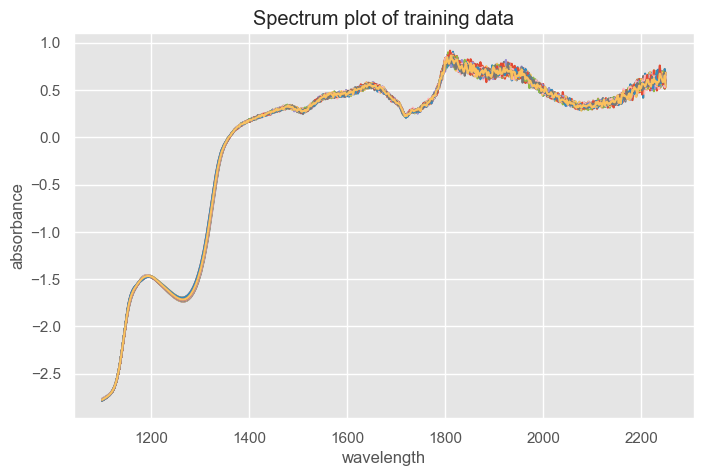

INFO [PRE PROCESSING]


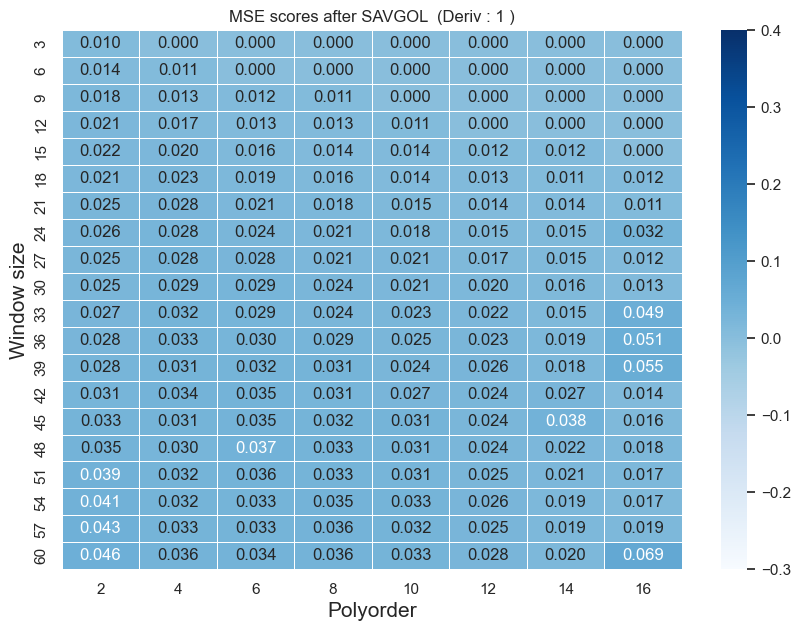

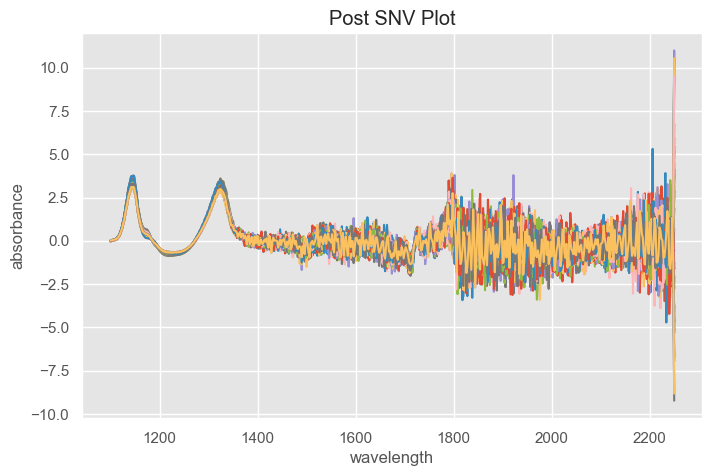

INFO Elapsed time for pipeline run : 1.04
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol2+snv, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


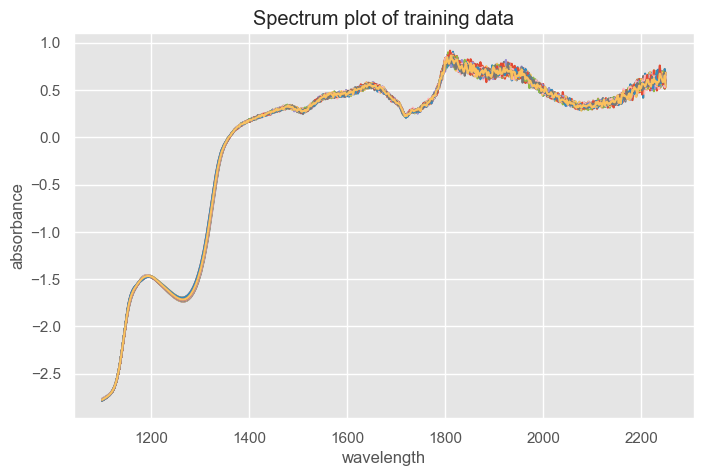

INFO [PRE PROCESSING]


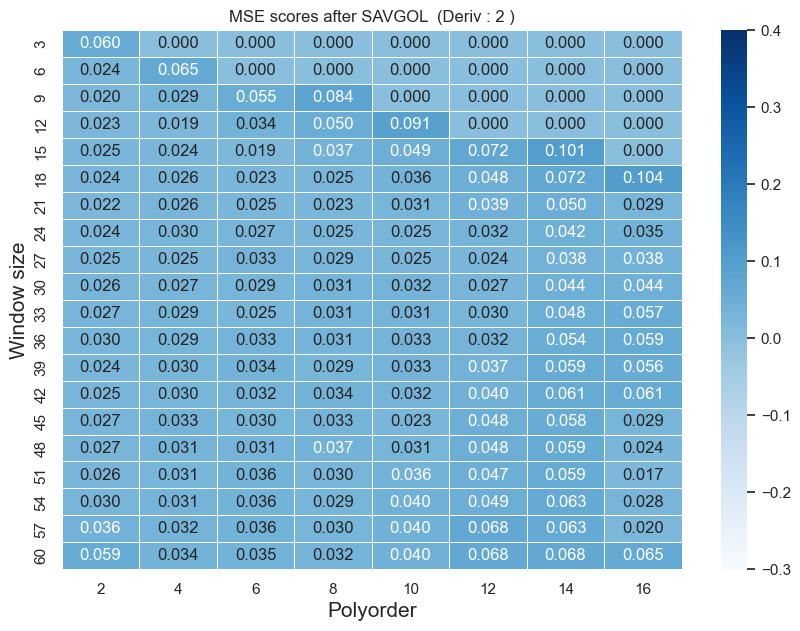

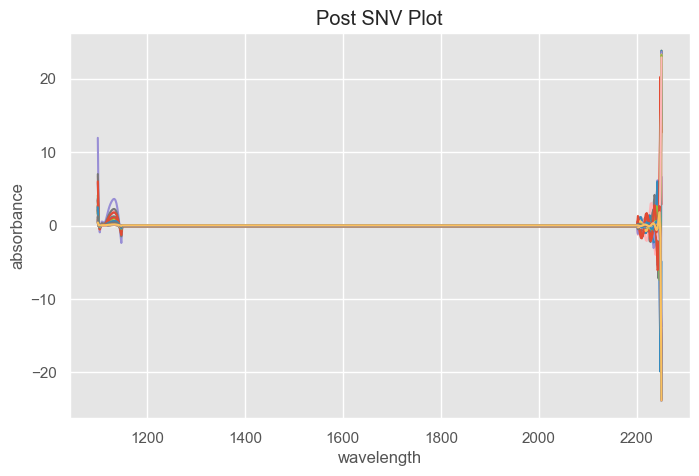

INFO Elapsed time for pipeline run : 1.13
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol0+msc, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


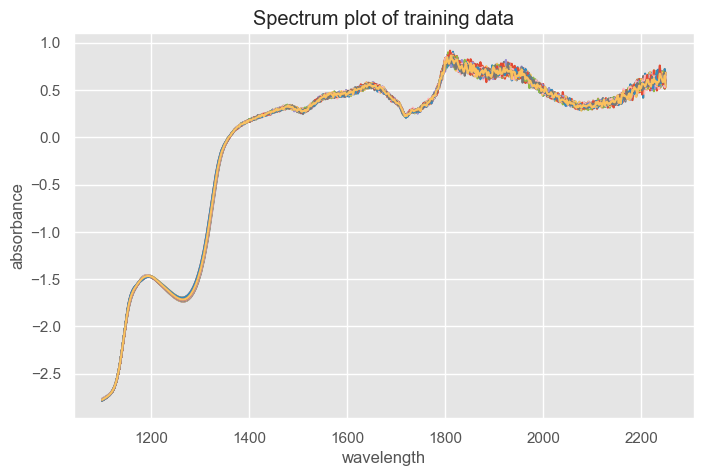

INFO [PRE PROCESSING]


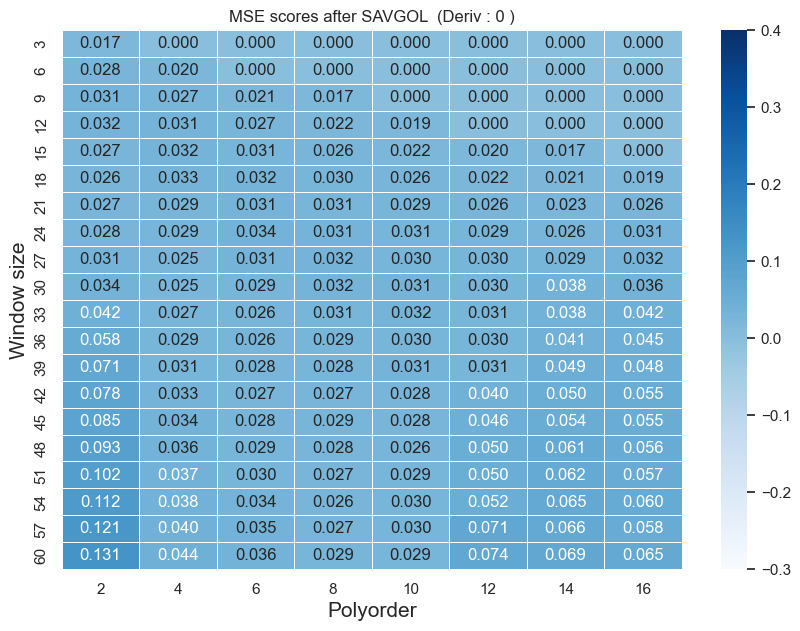

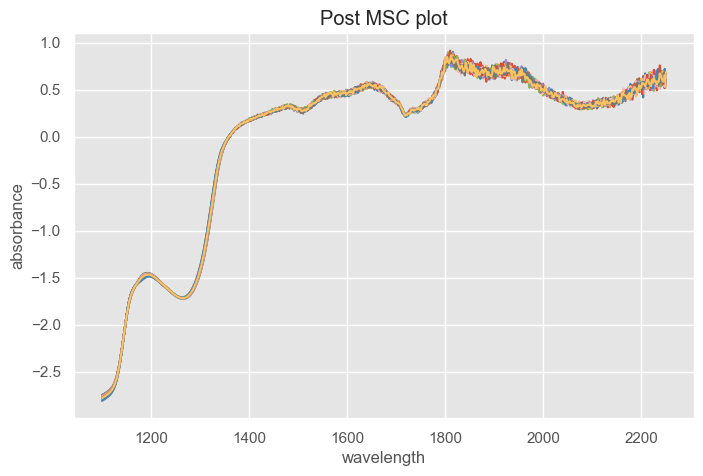

INFO Elapsed time for pipeline run : 1.09
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol1+msc, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


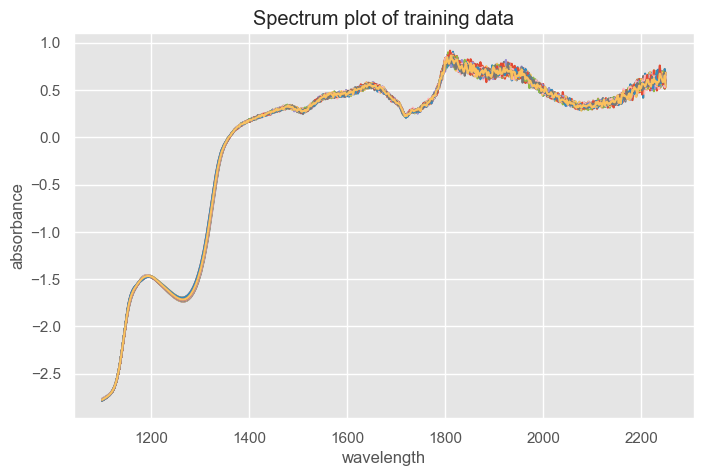

INFO [PRE PROCESSING]


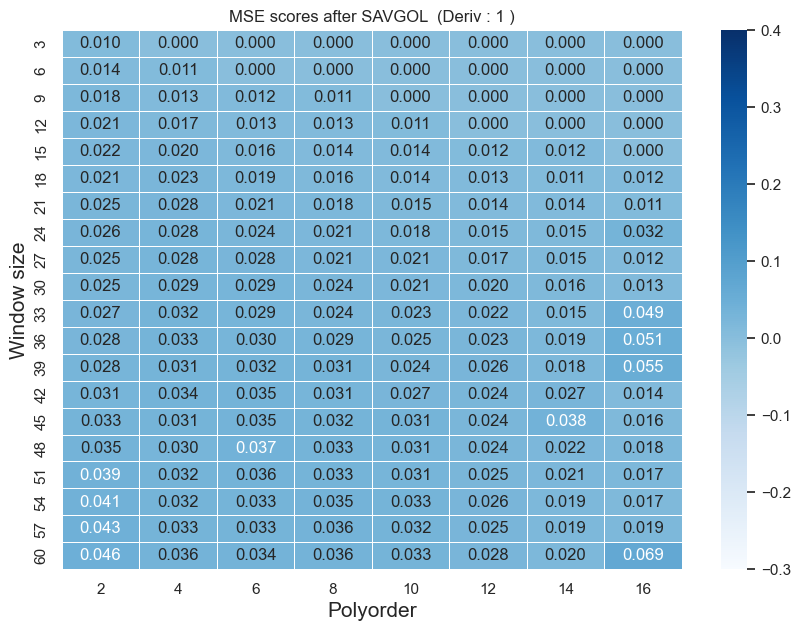

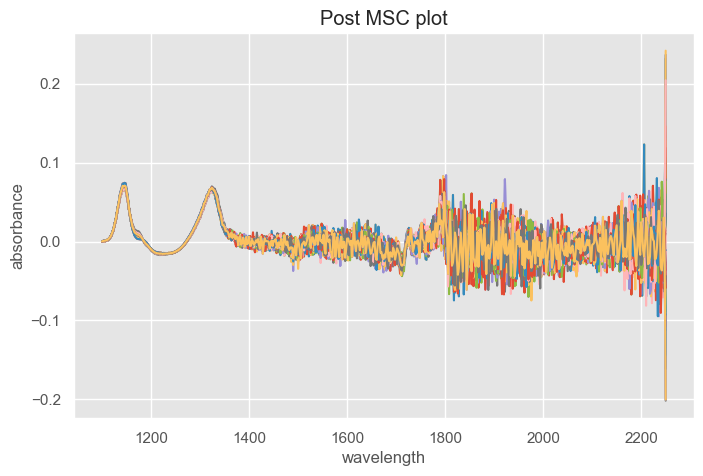

INFO Elapsed time for pipeline run : 1.19
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : beer_dataset.csv , Preprocessor : savgol2+msc, Model : pls, Evaluator : mseValidation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5


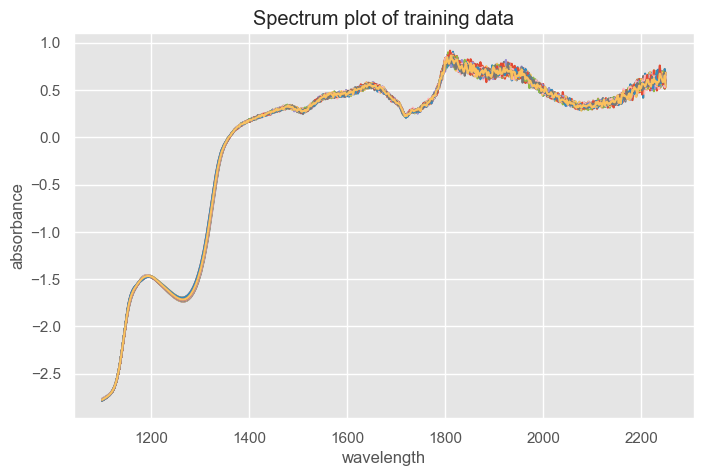

INFO [PRE PROCESSING]


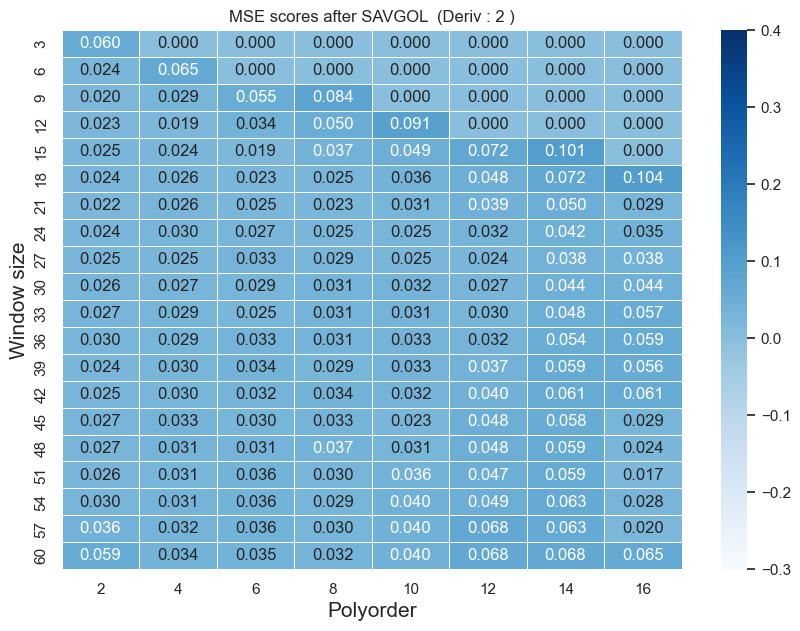

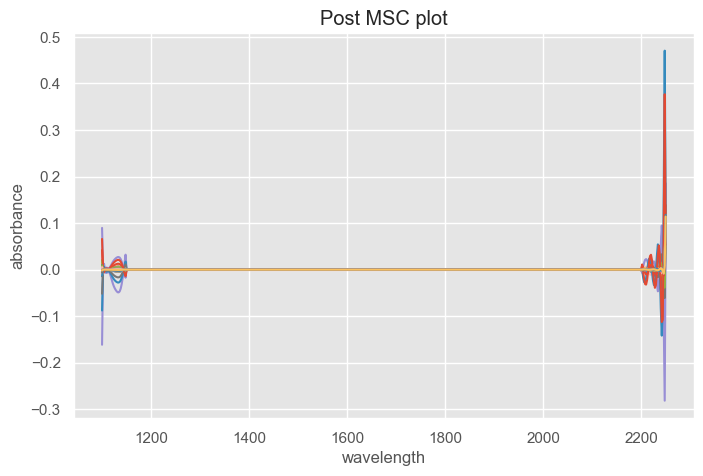

INFO Elapsed time for pipeline run : 1.1
INFO Pipeline end...
INFO ************************************


In [23]:
# Run pipeline in loop for all preprocessors combinations OR
# For selected preprocessors only, you can run the loop using a slice from the whole preprocessors list variable.
# To check which slice you want, check the configfile.ini file
for index, val in enumerate(preprocessors):
    if index in [0, 5, 8]:
        derivative = 0
    elif index in [1, 6, 9]:
        derivative = 1
    elif index in [2, 7, 10]:
        derivative = 2

    # Ideally not required to change anything here.
    # But you can change the derivative explicitly as per your choice (0,1 or 2)
    preprocessor_params = {
        'savgol' : {
            'window_size_range' : np.arange(3,63,3),
            'polyorder_range' : np.arange(2,18,2),
            'derivative' : derivative
        }
    }

    # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
    # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
    # Set models[0] for PLS and models[1] for LASSO
    # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
    # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
    # preprocessor-params: only required for SavGol and its related combos.
    # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
    pipeline_params = {
        'logger' : logger,
        'data' : data,
        'validation-type' : validation_types[0],
        'preprocessor' : val,
        'preprocessor-params' : preprocessor_params,
        'model' : models[0],
        'evaluator' : evaluators[0],
        'pls_max_n_comp' : int(pls_max_n_comp),
        'folds' : int(folds),
        'wl' : wl,
        'plotting' : True,
        'showModelEvaluationPlots' : True,
        'pipeline_run_type' : pipeline_run_types[0]
    }

    start = timer()
    logger.info("Pipeline Start...")
    logger.info("Parameters :")
    params = "Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor']) + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']) + "Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : " + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds'])
    logger.info(params)
    util.pipeline(pipeline_params)
    end = timer()
    logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
    logger.info("Pipeline end...")
    logger.info("************************************")


<h3 style="color: #00faaa">Running pipeline (total) for only Savgol1, SNV, MSC, Savgol1+SNV, Savgol1+MSC</h3>
<h5 style="color: white">Train/Test split - 80/20 OR 70/30 (needs to be set in params)</h5>
<h5 style="color: white">Validation method - KFolds CV, folds=5</h5>
<h5 style="color: white">Spectrum - 1 day</h5>